In [268]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from geocat.viz import util as gvutil
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geocat.viz import cmaps as gvcmaps

### Read OISSTv2

In [371]:
# land-sea masking
#lsmask = xr.open_dataset("/mnt/e/OISSTv2/lsmask.oisst.v2.nc")['lsmask'].squeeze()

# Read OISSTv2 datasets.
mean = xr.open_dataset("/mnt/e/OISSTv2/sst.day.mean.2018.nc")['sst']
anom = xr.open_dataset("/mnt/e/OISSTv2/sst.day.anom.2018.nc")['anom']
err = xr.open_dataset("/mnt/e/OISSTv2/sst.day.err.2018.nc")['err']
clim = xr.open_dataset("/mnt/e/OISSTv2/sst.day.mean.ltm.1991-2020.nc")['sst']
#clim1 = xr.open_dataset("/mnt/e/OISSTv2/sst.day.mean.ltm.1982-2010.nc")['sst']

# Set a period range for this study and extract it from the Dataset.
date_range = pd.date_range('2018-07-01 00:00:00', '2018-09-06 00:00:00', freq='1D')
mean = mean.sel(time=date_range)
anom = anom.sel(time=date_range)
err = err.sel(time=date_range)
clim = clim.isel(time=mean.time.dt.dayofyear.values-1)
#clim1 = clim1.isel(time=mean.time.dt.dayofyear.values-1)

# Extract regional basin around Korean Peninsula
minLon, maxLon, minLat, maxLat = [123, 129, 32, 39]
lon_slice, lat_slice = slice(minLon, maxLon), slice(minLat, maxLat)
mean = mean.sel(lon=lon_slice, lat=lat_slice)
anom = anom.sel(lon=lon_slice, lat=lat_slice)
err = err.sel(lon=lon_slice, lat=lat_slice)
clim = clim.sel(lon=lon_slice, lat=lat_slice)
clim['time'] = mean['time']
#clim1 = clim1.sel(lon=lon_slice, lat=lat_slice)
#clim1['time'] = mean['time']

# If the error is greater than 0.2, drop it.
crit_err = 0.2
mean = mean.where(err<crit_err)
anom = anom.where(err<crit_err)
clim = clim.where(err<crit_err)
#clim1 = clim1.where(err<crit_err)

# Create a latitude weight and apply it to all variables.
weights = np.cos(np.deg2rad(mean.lat))
weights.name = "weights"
weighted_mean = mean.weighted(weights).mean(("lon","lat"))
weighted_anom = anom.weighted(weights).mean(("lon","lat"))
weighted_clim = clim.weighted(weights).mean(("lon","lat"))
#weighted_clim1 = clim1.weighted(weights).mean(("lon","lat"))

/home/siyang/miniconda3/envs/jupyter/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/siyang/miniconda3/envs/jupyter/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/siyang/miniconda3/envs/jupyter/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/siyang/miniconda3/envs/jupyt

### Visualization

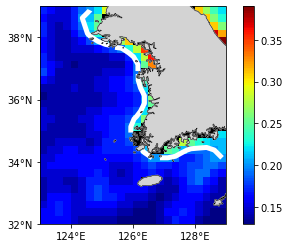

In [377]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.coastlines(linewidths=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
mesh = ax.pcolormesh(err.lon, err.lat, err.sel(time="2018-08-10"), cmap=gvcmaps.MPL_jet)
cbar = fig.colorbar(mesh)
cs = ax.contour(err.lon, err.lat, err.sel(time="2018-08-10"), colors='w', linewidths=[5], levels=[0.2])
gvutil.set_axes_limits_and_ticks(ax,xlim=(minLon, maxLon), ylim=(minLat, maxLat),
                                 xticks=np.arange(120, 130, 2),
                                 yticks=np.arange(30, 42, 2))
gvutil.add_lat_lon_ticklabels(ax)

ax.coastlines(linewidths=0.5, zorder=101)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=100)

#plt.show()
fig.savefig('fig_OISSTv2_dist_err_20180810.png', dpi=500, bbox_inches='tight')

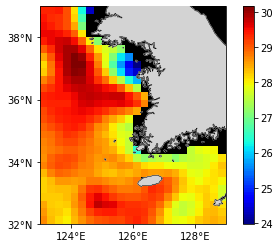

In [368]:
fig, ax = plt.subplots(1,1, subplot_kw=dict(projection=ccrs.PlateCarree()))

cmap = gvcmaps.MPL_jet.copy()
cmap.set_bad("k")
mesh = ax.pcolormesh(mean.lon, mean.lat, mean.sel(time="2018-08-10"), cmap=cmap, zorder=1)
cbar = fig.colorbar(mesh)
gvutil.set_axes_limits_and_ticks(ax,xlim=(minLon, maxLon), ylim=(minLat, maxLat),
                                 xticks=np.arange(120, 130, 2),
                                 yticks=np.arange(30, 42, 2))
gvutil.add_lat_lon_ticklabels(ax)

ax.coastlines(linewidths=0.5, zorder=101)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=100)

#plt.show()
fig.savefig('fig_OISSTv2_dist_mean_20180810.png', dpi=500, bbox_inches='tight')

 *spin-up (week):      2018-07-15 00:00:00 ~ 2018-07-22 00:00:00
 *simulation (month):  2018-07-22 00:00:00 ~ 2018-08-22 00:00:00


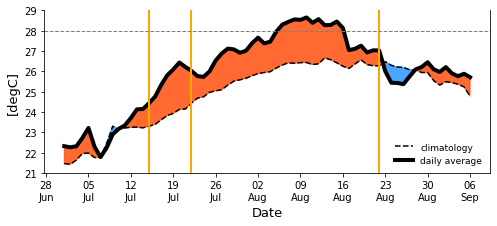

In [369]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

loc = plticker.MultipleLocator(base=7)

ax.plot(mean.time, weighted_clim, lw=1.5, color='k', label='climatology', ls='--')
ax.plot(mean.time, weighted_mean, lw=4, color='k', label='daily average')

ax.fill_between(mean.time, weighted_mean, weighted_clim, 
                where=(weighted_mean > weighted_clim), 
                color='orangered', alpha=0.8, interpolate=True)
ax.fill_between(mean.time, weighted_mean, weighted_clim, 
                where=(weighted_mean < weighted_clim), 
                color='dodgerblue', alpha=0.8, interpolate=True)

date0 = datetime(2018, 7, 15, 0, 0)
date1 = date0 + timedelta(days=7)
date2 = date1 + timedelta(days=31)
print(" *spin-up (week):     ", date0, '~', date1)
print(" *simulation (month): ", date1, '~', date2)
for d in [date0, date1, date2]:
    ax.axvline(d, color='k', c='orange', lw=2)
    
ax.set_yticks(np.arange(21,30,1))
ax.spines['top'].set_visible(False)
#ax.set_title('Time series for weighted mean SST', fontsize=18)
ax.set_ylabel('[degC]', fontsize=13)
ax.set_xlabel('Date', fontsize=13)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.axhline(28, color='grey',  lw=1, ls='--')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))

ax.legend(loc='best', prop=dict(size=9), frameon=False)
fig.savefig('fig_OISSTv2_ts_mean.png', dpi=500, bbox_inches='tight')

 *spin-up (week):      2018-07-15 00:00:00 ~ 2018-07-22 00:00:00
 *simulation (month):  2018-07-22 00:00:00 ~ 2018-08-22 00:00:00


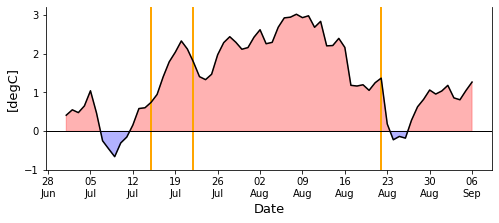

In [370]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

loc = plticker.MultipleLocator(base=7)

date0 = datetime(2018, 7, 15, 0, 0)
date1 = date0 + timedelta(days=7)
date2 = date1 + timedelta(days=31)

print(" *spin-up (week):     ", date0, '~', date1)
print(" *simulation (month): ", date1, '~', date2)

for d in [date0, date1, date2]:
    ax.axvline(d, color='k', c='orange', lw=2)

ax.plot(mean.time, weighted_anom, lw=1.5, ls='-', color='k')
ax.fill_between(mean.time, weighted_anom, where=(weighted_anom > 0), color='red', alpha=0.3, interpolate=True)
ax.fill_between(mean.time, weighted_anom, where=(weighted_anom < 0), color='blue', alpha=0.3, interpolate=True)
ax.set_yticks(np.linspace(-1,3,5))  
ax.axhline(0, color='k', lw=1)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('[degC]', fontsize=13)
ax.set_xlabel('Date', fontsize=13)

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))

fig.savefig('fig_OISSTv2_ts_anom.png', dpi=500, bbox_inches='tight')